In [22]:
# import numpy as np
from typing import List
from copy import deepcopy
import random
import math

# Matrix
class Matrix:
    def __init__(self, data: List[List[float]]):
        self.data = data
        self.nrows = len(data)
        self.ncols = len(data[0]) if data else 0

    def __getitem__(self, idx):
        return self.data[idx]

    def __setitem__(self, idx, value):
        self.data[idx] = value

    def __repr__(self):
        return f"Matrix({self.data})"
    
    
EPS = 1e-8         

def ladder_form(A, eps: float = EPS):
    A = [row[:] for row in A]
    nrows, ncols = len(A), len(A[0])
    r = 0
    for c in range(ncols):
        if r >= nrows:
            break
        # поиск строки‑pivot
        pivot = next((i for i in range(r, nrows) if abs(A[i][c]) > eps), None)
        if pivot is None:
            continue
        A[r], A[pivot] = A[pivot], A[r] 
        lv = A[r][c]
        A[r] = [v / lv for v in A[r]] 
        for i in range(nrows): 
            if i != r:
                factor = A[i][c]
                A[i] = [iv - factor * rv for iv, rv in zip(A[i], A[r])]
        # подчистим мелкие числа
        for i in range(nrows):
            for j in range(ncols):
                if abs(A[i][j]) < eps:
                    A[i][j] = 0.0
        r += 1
    return A


In [23]:
def gauss_solver(A_raw, b_raw):
    """
    Вход:
    A: матрица коэффициентов (n×n). Используется класс Matrix из предыдущей
    лабораторной работы
    →
    b: вектор правых частей (n×1)
    Выход:
    list[Matrix]: список базисных векторов решения системы
    Raises:
    ValueError: если система несовместна
    """
    A = [row[:] for row in A_raw]
    b = [row[0] for row in b_raw]

    n = len(A)        # количество строк
    m = len(A[0])     # количество столбцов

    Ab = [A[i] + [b[i]] for i in range(n)]
    Ab_lad = ladder_form(Ab)

    A_lad = [Ab_lad[i][:-1] for i in range(len(Ab_lad))]
    b_lad = [Ab_lad[i][-1] for i in range(len(Ab_lad))]

     # Проверка на несовместность системы
    for i in range(n):
        if all(abs(A_lad[i][j]) < EPS for j in range(n)) and abs(b_lad[i]) > EPS:
            raise ValueError("Система несовместна")
         

    ladder_matrix = Ab_lad.copy()
    # Ищем ведущие переменные (pivots) — первые ненулевые элементы в строках
    pivots = []
    for i, row in enumerate(ladder_matrix):
        for j in range(m):  # не включая последний столбец (b)
            if abs(row[j]) > EPS:
                pivots.append(j)
                break  # Переходим к следующей строке после первого ненуля

    # Строим частное решение (одно конкретное решение, если оно существует)
    x_particular = [0] * m
    for i, row in enumerate(ladder_matrix):
        for j in range(m):
            if abs(row[j]) > EPS:
                x_particular[j] = row[-1]  # Последний столбец — значения правой части
                break
    # Определяем свободные переменные (те, что не являются ведущими)
    free_vars = [j for j in range(m) if j not in pivots]
    kernel = []  # Список базисных векторов ядра

    # Для каждой свободной переменной строим базисный вектор ядра
    for free in free_vars:
        vec = [0] * m
        vec[free] = 1  # Свободной переменной присваиваем 1

        # Остальные выражаем через неё из системы (по строкам)
        for i in range(len(pivots)):
            pivot_col = pivots[i]
            vec[pivot_col] = -ladder_matrix[i][free]  # Сдвигаем в другую сторону
        kernel.append(vec)

    # Возвращаем частное решение как Matrix (вектор-столбец) и базис ядра как список Matrix
    # return [Matrix([[x] for x in x_particular])] + [Matrix([[x] for x in v]) for v in kernel]
    return [Matrix([[x] for x in v]) for v in kernel]


A = [
        [2, 1],
        [4, 2]
    ]

b = [
    [5],
    [10]
]


gauss_solver(A,b)

[Matrix([[-0.5], [1]])]

## Easy 2

In [24]:
def center_data(X: 'Matrix') -> 'Matrix':
    """
    Вход: матрица данных X (n×m)
    Выход: центрированная матрица X_centered (n×m),
           из каждого признака (столбца) вычтено его среднее.
    """
    n, m = X.nrows, X.ncols

    means = [sum(X[i][j] for i in range(n)) / n for j in range(m)]

    centered_data = [[X[i][j] - means[j] for j in range(m)] for i in range(n)]

    return Matrix(centered_data)


## Easy 3

In [25]:
def covariance_matrix(X_centered: 'Matrix') -> 'Matrix':
    """
    Вход: центрированная матрица X_centered (n×m)
    Выход: матрица ковариаций C (m×m)
    """
    n = X_centered.nrows
    m = X_centered.ncols
    cov_data = [[0.0 for _ in range(m)] for _ in range(m)]
    
    for i in range(m):
        for j in range(m):
            cov = sum(X_centered.data[k][i] * X_centered.data[k][j] for k in range(n)) / (n - 1)
            cov_data[i][j] = cov
            
    return Matrix(cov_data)


## Normal 1

In [26]:
def determinant(matrix: List[List[float]]) -> float:
    """Вычисление определителя матрицы"""
    n = len(matrix)
    if n == 1:
        return matrix[0][0]
    if n == 2:
        return matrix[0][0]*matrix[1][1] - matrix[0][1]*matrix[1][0]
    
    det = 0
    for j in range(n):
        submatrix = [row[:j] + row[j+1:] for row in matrix[1:]]
        det += ((-1)**j) * matrix[0][j] * determinant(submatrix)
        
    return det

def subtract_lambda_I(A: List[List[float]], lam: float) -> List[List[float]]:
    """
    Формирует матрицу A - λI, где I — единичная матрица.
    """
    n = len(A)
    return [[A[i][j] - (lam if i == j else 0) for j in range(n)] for i in range(n)]

def characteristic_polynomial(A: List[List[float]], lam: float) -> float:
    """
    Вычисляет характеристический многочлен: det(A - λI).
    """
    M = subtract_lambda_I(A, lam)
    return determinant(M)

def gershgorin_bounds(A: List[List[float]]) -> (float, float):
    """
    Оценка границ для собственных значений матрицы A по теореме Гершгорина.
    Для каждой строки i оценивается интервал:
        [A[i][i] - R_i, A[i][i] + R_i],
    где R_i = сумма модулей недиагональных элементов.
    Возвращает (нижнюю, верхнюю) границу по всем строкам.
    """
    n = len(A)
    lower_bound = float('inf')
    upper_bound = float('-inf')
    for i in range(n):
        row_sum = sum(abs(A[i][j]) for j in range(n) if j != i)
        lower_bound = min(lower_bound, A[i][i] - row_sum)
        upper_bound = max(upper_bound, A[i][i] + row_sum)
    return lower_bound, upper_bound


In [27]:
def sign_changes_intervals(f, a: float, b: float, num: int = 10000) -> List[tuple]:
    """
    находит отрезки с меняющимся знаком
    """
    dx = (b - a) / num
    intervals = []
    x_prev = a
    f_prev = f(x_prev)
    for i in range(1, num + 1):
        x_curr = a + i * dx
        f_curr = f(x_curr)
        if f_prev * f_curr < 0:
            intervals.append((x_prev, x_curr))
        x_prev, f_prev = x_curr, f_curr
    return intervals

def bisection(f, a: float, b: float, tol: float) -> float:
    """
    Метод бисекции для нахождения одного корня уравнения f(λ)=0 
    """
    fa, fb = f(a), f(b)
    if fa * fb > 0:
        return False
    
    while (b - a) > tol:
        c = (a + b) / 2
        fc = f(c)
        if abs(fc) < tol:
            return c
        if fa * fc < 0:
            b, fb = c, fc
        else:
            a, fa = c, fc
    return (a + b) / 2

def find_eigenvalues(A: Matrix, tol: float = 1e-12) -> List[float]:
    """
    Находит собственные значения симметричной матрицы A методом бисекции.
    """
    A = A.data
    a, b = gershgorin_bounds(A)
    
    f = lambda lam: characteristic_polynomial(A, lam)
    
    intervals = sign_changes_intervals(f, a, b, num=10000)
    
    eigenvalues = []
    for (left, right) in intervals:
        root = bisection(f, left, right, tol)
        if root is not False:
            eigenvalues.append(root)
        else:
            continue
    
    return sorted(eigenvalues, reverse=True)



In [28]:
A = Matrix([
        [2, 1,3 ],
        [4, 2, 4],
        [5, 1, 4]
    ])
eigenvalues = find_eigenvalues(A,)
eigenvalues

[8.274917217635362, 0.7250827823646367]

## Normal 2

In [29]:
def find_eigenvectors(C: 'Matrix', eigenvalues: List[float])-> List['Matrix']:
    """
    Вход:
    C: матрица ковариаций (m×m)
    eigenvalues: список собственных значений
    Выход: список собственных векторов (каждый вектор- объект Matrix)
    """
    vectors_eigen = []
    n = C.ncols
    for lam in eigenvalues:
        C_mod = [[C[i][j] - (lam if i == j else 0.0) for j in range(n)] for i in range(n)]
        kernel = gauss_solver(C_mod, [[0] for _ in range(n)])

        vectors_eigen.extend(kernel)     
    return vectors_eigen

C = Matrix([
        [2.0, 1.0],
        [1.0, 2.0]
    ])

eigenvalues = [1.0, 3.0]

eigenvectors_basis = find_eigenvectors(C, eigenvalues)
for i, basis in enumerate(eigenvectors_basis):
    print(f"Базис собственного подпространства для λ = {eigenvalues[i]}:")
    for vec in basis:
        print(vec)

Базис собственного подпространства для λ = 1.0:
[-1.0]
[1]
Базис собственного подпространства для λ = 3.0:
[1.0]
[1]


In [30]:
list(Matrix([[-1.0], [1]]))

[[-1.0], [1]]

## Normal 3

In [31]:
def explained_variance_ratio(eigenvalues: List[float], k: int)-> float:
    """
    Вход:
    eigenvalues: список собственных значений
    k: число компонент
    Выход: доля объяснённой дисперсии
    """
    eigenvalues = sorted(eigenvalues, reverse=True)
    s_k = 0
    s_all = 0
    
    if not eigenvalues:
        raise ValueError("Список собственных значений пуст.")
    if k <= 0 or k > len(eigenvalues):
        raise ValueError("k должно быть положительным и не превышать число собственных значений.")


    for i in range(len(eigenvalues)):
        if i<k:
            s_k += eigenvalues[i]
        s_all += eigenvalues[i]
        
    return s_k / s_all

eigenvalues = [5.0, 3.0, 1.0]  

explained_variance_ratio(eigenvalues, 2)

0.8888888888888888

## HARD 1

In [32]:
def matrix_multiply(A: Matrix, B: Matrix) -> Matrix:
    """
    Перемножает две матрицы
    """
    n = A.nrows
    m = A.ncols
    k = B.ncols
    result_data = [[0.0 for _ in range(k)] for _ in range(n)]
    for i in range(n):
        for j in range(k):
            s = 0.0
            for l in range(m):
                s += A.data[i][l] * B.data[l][j]
            result_data[i][j] = s
    return Matrix(result_data)


def hstack_matrices(cols: List[Matrix]) -> Matrix:
    if not cols:
        raise ValueError("Нет матриц для объединения")

    n_rows = cols[0].nrows
    data = [[col[i][0] for col in cols] for i in range(n_rows)]
    return Matrix(data)


In [33]:
from typing import List, Tuple

def pca(X: 'Matrix', k: int)-> Tuple['Matrix', float]:
    """
    Вход:
    X: матрица данных (n×m)
    k: число главных компонент
    Выход:
    X_proj: проекция данных (n×k)
    : доля объяснённой дисперсии
    """
    X_centered = center_data(X)
    C = covariance_matrix(X_centered)  
    
    eigenvals = find_eigenvalues(C) 
    eigenvecs = list(find_eigenvectors(C, eigenvals))
    principal_vectors = eigenvecs[:k]
    W = hstack_matrices(principal_vectors)
    X_projection = matrix_multiply(X_centered, W)
    
    explained_var = explained_variance_ratio(eigenvals, k)
    
    return X_projection, explained_var
    
    

In [34]:
X_data = [
    [2, 1, 3],
    [4, 2, 4],
    [5, 1, 4]
]
X = Matrix(X_data)

X_proj, var_ratio = pca(X, k=2)
print(X_proj)          
print(var_ratio)      


Matrix([[-5.309401076761123, -0.6905989232616239], [1.4226497308109773, 2.5773502692547035], [3.8867513459501466, -1.8867513459930785]])
1.000000000000331


## HARD 2

C:\Users\admin\AppData\Local\Temp\ipykernel_8408\1316003586.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


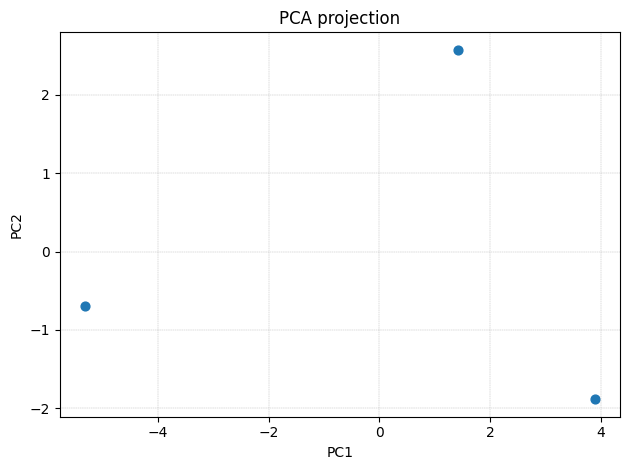

In [35]:
from matplotlib.figure import Figure
import matplotlib.pyplot as plt

def plot_pca_projection(X_proj: 'Matrix') -> Figure:
    x = [row[0] for row in X_proj.data]   
    y = [row[1] for row in X_proj.data]  

    fig, ax = plt.subplots()
    ax.scatter(x, y, s=40)              
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title("PCA projection")
    ax.grid(True, ls="--", lw=0.3)
    fig.tight_layout()

    return fig

fig = plot_pca_projection(X_proj)
fig.show()            

## HARD 3

In [36]:
def reconstruction_error(X_orig: 'Matrix', X_recon: 'Matrix') -> float:
    """
    Вход:
    X_orig: исходные данные (n×m)
    X_recon: восстановленные данные (n×m)
    Выход: среднеквадратическая ошибка MSE
    """

    n, m = X_orig.nrows, X_orig.ncols
    if n == 0 or m == 0:
        raise ValueError("Матрица пустая")

    sum = 0.0
    for i in range(n):
        for j in range(m):
            diff = X_orig[i][j] - X_recon[i][j]
            sum += diff * diff

    return sum / (n * m)


X_o = Matrix([[1, 2], [3, 4]])
X_r = Matrix([[0.9, 2.1], [3.2, 3.8]])
mse  = reconstruction_error(X_o, X_r)
print("MSE =", mse)            


MSE = 0.025000000000000036


## Expert 1

In [37]:
def auto_select_k(eigenvalues: List[float], threshold: float = 0.95) -> int:
    """
    Вход:
    eigenvalues: список собственных значений
    threshold: порог объяснённой дисперсии
    Выход: оптимальное число главных компонент k
    """

    eigvals = sorted(eigenvalues, reverse=True)
    total = sum(eigvals)
    running = 0.0

    for idx, val in enumerate(eigvals, start=1): 
        running += val
        if running / total >= threshold:
            return idx

    return len(eigvals)  

def pca_auto_k(X: 'Matrix', k: None, threshold: float = 0.95) -> Tuple['Matrix', float]:
    """
    Если k не указано, число главных компонент выбирается так, чтобы доля
    объяснённой дисперсии была ≥ threshold.
    """
    X_centered = center_data(X)
    C = covariance_matrix(X_centered)

    eigenvals = find_eigenvalues(C)
    eigenvecs = find_eigenvectors(C, eigenvals) 

    if k is None:
        k = auto_select_k(eigenvals, threshold)
    print(eigenvals)
    if k <= 0 or k > len(eigenvals):
        raise ValueError(f"Некорректное k = {k}")

    eigenpairs = sorted(zip(eigenvals, eigenvecs), key=lambda p: p[0], reverse=True)
    W = hstack_matrices([vec for _, vec in eigenpairs[:k]])  # матрица весов (m×k)

    X_proj = matrix_multiply(X_centered, W)

    var_ratio = explained_variance_ratio(eigenvals, k)

    return X_proj, var_ratio


X_proj, var_ratio = pca_auto_k(X, k=None, threshold=0.97)
print("k выбрано автоматически:", X_proj.ncols)
print("Доля объяснённой дисперсии:", var_ratio)


[2.654700538379078, 0.3452994616200527, -9.933367313883684e-13]
k выбрано автоматически: 2
Доля объяснённой дисперсии: 1.000000000000331


## EXPERT 2

In [38]:
import math

def is_nan(x: float) -> bool:
    return math.isnan(x)

def handle_missing_values(X: 'Matrix') -> 'Matrix':
    """
    Вход: матрица данных X (n×m) с возможными NaN
    Выход: матрица данных X_filled (n×m) без NaN
    """
    X_filled = deepcopy(X)
    nrows, ncols = X.nrows, X.ncols

    for j in range(ncols):
        col_values = []
        for i in range(nrows):
            val = X[i][j]
            if not is_nan(val):
                col_values.append(val)

        if col_values:
            col_mean = sum(col_values) / len(col_values)
        else:
            col_mean = 0.0  

        for i in range(nrows):
            if is_nan(X[i][j]):
                X_filled[i][j] = col_mean

    return X_filled

X_data = [
    [2.0, 1.0, float('nan')],
    [4.0, 2.0, 4.0],
    [5.0, float('nan'), 4.0]
]

X = Matrix(X_data)
X_filled = handle_missing_values(X)

print("Матрица после замены NaN:")
print(X_filled)


Матрица после замены NaN:
Matrix([[2.0, 1.0, 4.0], [4.0, 2.0, 4.0], [5.0, 1.5, 4.0]])


## Expert 3

In [39]:
def mean(values):
    return sum(values) / len(values)

def stddev(values, mu=None):
    if mu is None:
        mu = mean(values)
    return math.sqrt(sum((x - mu)**2 for x in values) / len(values))

def add_noise(X: 'Matrix', noise_level: float) -> 'Matrix':
    X_noisy = deepcopy(X)
    nrows, ncols = X.nrows, X.ncols

    # Вычисляем среднее и стандартное отклонение по каждому столбцу
    for j in range(ncols):
        col = [X[i][j] for i in range(nrows)]
        mu = mean(col)
        sigma = stddev(col, mu)
        noise_std = sigma * noise_level

        for i in range(nrows):
            noise = random.gauss(0, noise_std)
            X_noisy[i][j] += noise

    return X_noisy

def add_noise_and_analys(X: 'Matrix', ):
    print("PCA до добавления шума")
    X_proj_before, var_ratio_before = pca(X, k=2)
    print("Объяснённая дисперсия (до):", var_ratio_before)

    for noise_level in [0.1, 0.2, 0.5]:
        X_noisy = add_noise(X, noise_level)

        print("PCA после добавления шума c noise_level = ", noise_level)
        X_proj_after, var_ratio_after = pca(X_noisy, k=2)
        print("Объяснённая дисперсия (после):", var_ratio_after)
        # Анализ:
        diff = var_ratio_before- var_ratio_after
        print("Изменения в доле объяснённой дисперсии по компонентам:", diff)
        print()
        
    print(f"Добавление шумов всех уровней изменило структуру данных")
    print("PCA оказался устойчив к небольшому шуму.")
    
    print()

In [40]:
X_data = Matrix([
    [2.5, 3.0, 2.8, 3.2, 3.1],
    [3.0, 3.5, 3.2, 3.8, 3.6],
    [2.8, 3.2, 3.0, 3.4, 3.3],
    [3.2, 3.8, 3.5, 4.0, 3.9],
    [2.9, 3.4, 3.1, 3.6, 3.5]
])

add_noise_and_analys(X_data)
# X_centered = center_data(X_data)
# # C = covariance_matrix(X_centered).data

# eigenvalues = find_eigenvalues(X_centered)
# eigenvalues

PCA до добавления шума
Объяснённая дисперсия (до): 0.9999879248410352
PCA после добавления шума c noise_level =  0.1
Объяснённая дисперсия (после): 0.9934970489662557
Изменения в доле объяснённой дисперсии по компонентам: 0.006490875874779478

PCA после добавления шума c noise_level =  0.2
Объяснённая дисперсия (после): 0.9908401486407683
Изменения в доле объяснённой дисперсии по компонентам: 0.009147776200266855

PCA после добавления шума c noise_level =  0.5
Объяснённая дисперсия (после): 0.9738586171955448
Изменения в доле объяснённой дисперсии по компонентам: 0.026129307645490374

Добавление шумов всех уровней изменило структуру данных
PCA оказался устойчив к небольшому шуму.



## Expert 4

In [41]:
import csv

def load_dataset_to_matrix(filename: str) -> Matrix:
    data = []
    with open(filename, newline='') as csvfile:
        csvreader = csv.reader(csvfile)
        for row in csvreader:
            try:
                data.append([float(value) for value in row])
            except:
                continue

    return Matrix(data)

dataset = "diabetes.csv"  
dataset_matrix = load_dataset_to_matrix(dataset)


In [ ]:
def apply_pca_to_dataset(dataset_name: str, k: int)-> Tuple['Matrix', float]:
    """
    Вход:
    dataset_name: название датасета
    k: число главных компонент
    Выход: кортеж (проекция данных, качество модели)
    """
    dataset_matrix = load_dataset_to_matrix(dataset_name)
        
    X, var_ratio = pca(dataset_matrix, k=k)
    return tuple(X, var_ratio)

a, b = apply_pca_to_dataset("diabetes.csv", 2)
print("Объяснённая дисперсия:", b)
